## Chapter 27: Optimization

This Chapter covers how to find the maximum or minimum of a function. We'll start with simple functions of 1 variable and move to functions of 2 variables. 

In [1]:
using Plots, Revise

We'll start with a simple parabola:

In [2]:
f(x) = (x-1)^2

f (generic function with 1 method)

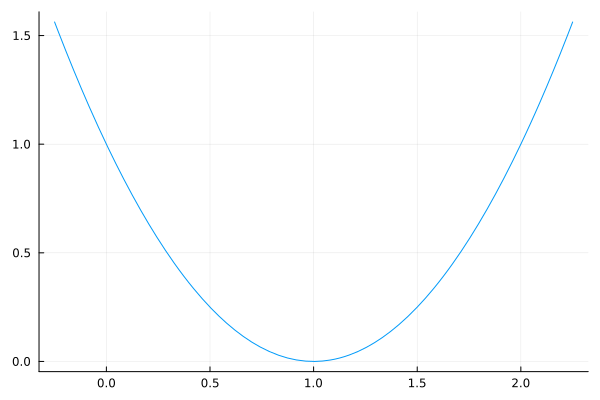

In [3]:
plot(f,-0.25,2.25,legend=false)

In [4]:
includet("../julia-files/Rootfinding.jl")
using .Rootfinding, ForwardDiff, LinearAlgebra

To find the minimum, we'll seach for where the derivative is 0.  Instead of taking the derivative, though, we'll use the automatic differentiation in the `ForwardDiff` package.

In [5]:
newton(x->ForwardDiff.derivative(f,x),0)

The root is approximately x̂ = 1.0
An estimate for the error is 0.0
with f(x̂) = 0.0
which took 1 steps

Well that was fast.  The reason it was, however was that the derivative was a linear function. 

In [6]:
f2(x) = sin(x)^2

f2 (generic function with 1 method)

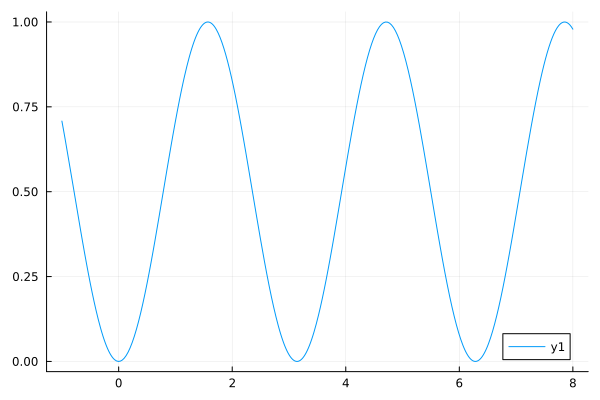

In [7]:
plot(f2,-1,8)

From the plot above, there are a lot of local minima.  We'll try to find the one new 3.5

In [8]:
newton(x->ForwardDiff.derivative(f2,x),3.5)

The root is approximately x̂ = 3.141592653268623
An estimate for the error is -3.2117032400955357e-10
with f(x̂) = -6.423406480191071e-10
which took 3 steps

#### Optimizing functions of more that one variable

Let's examine a function of two variables.  The following is a circular paraboloid, which you can think of as a parabola that is 

In [9]:
g(x::Vector) = x[1]^2+x[2]^2

g (generic function with 1 method)

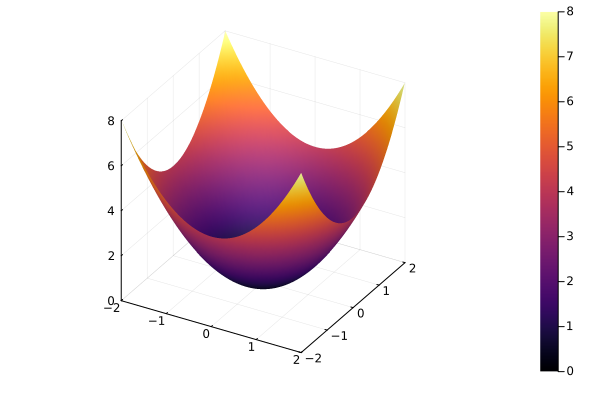

In [10]:
xrange = LinRange(-2,2,101)
yrange = LinRange(-2,2,101)
surface(xrange,yrange,(x,y)->g([x,y]))

The following is a contour plot of the same:

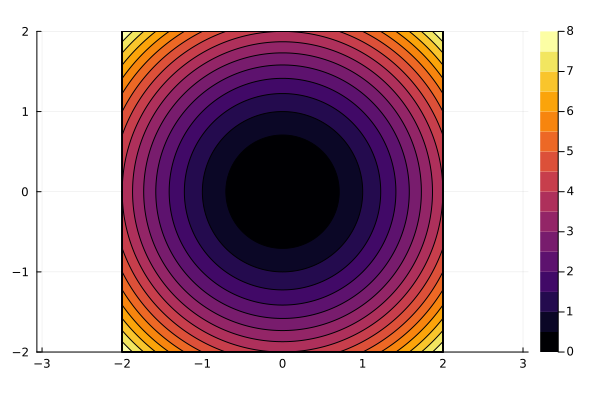

In [11]:
xrange = LinRange(-2,2,251)
yrange = LinRange(-2,2,251)
contour(xrange,yrange,(x,y)->g([x,y]), aspect_ratio = :equal, fill=true)

In [12]:
ForwardDiff.gradient(g,[0.5,1])

2-element Vector{Float64}:
 1.0
 2.0

We're going to look at the steepest descent method which take a point somewhere and moving opposite the gradient, which is the direction of steepest descent.  

In [13]:
function gradientDescent(f::Function,x₀::Vector; γ = 0.25, max_steps = 100)
  local steps = 0
  local ∇f₀ = [1,1] # initialize it to get into while loop
  while norm(∇f₀)> 1e-8 && steps < max_steps
    ∇f₀ = ForwardDiff.gradient(f,x₀)
    x₀ -= γ*∇f₀
    steps += 1
  end
  steps < max_steps || throw(ErrorException("The number of steps has exceeded $max_steps"))
  @show steps
  x₀
end

gradientDescent (generic function with 1 method)

In [14]:
gradientDescent(g,[0.5,1])

steps = 29


2-element Vector{Float64}:
 9.313225746154785e-10
 1.862645149230957e-9

Let's look at another function (this is famous in optimization circles):

In [15]:
rose(x::Vector) = (1-x[1])^2+50*(x[2]-x[1]^2)^2

rose (generic function with 1 method)

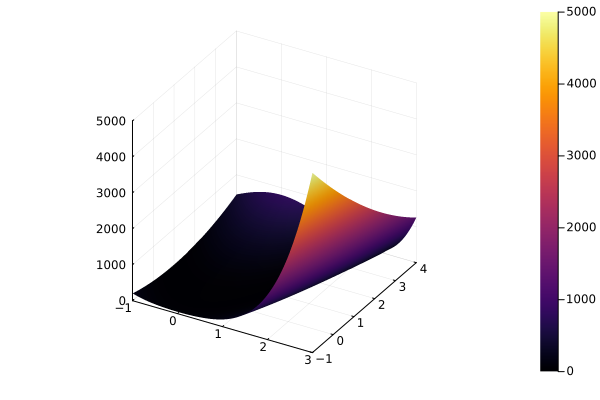

In [16]:
xrange = LinRange(-1,3,251)
yrange = LinRange(-1,4,251)
surface(xrange,yrange,(x,y)->rose([x,y]))

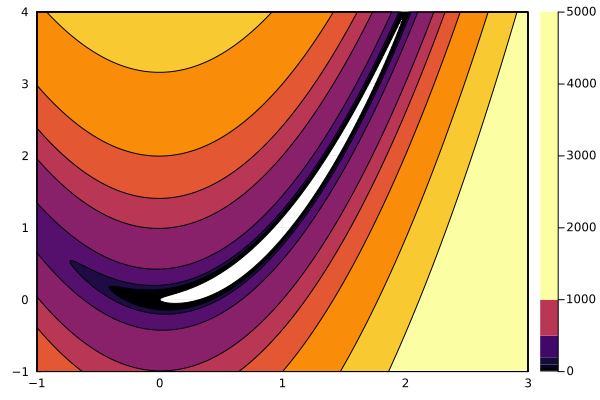

In [17]:
contour(xrange,yrange,(x,y)->rose([x,y]),levels=[1,2,3,10,50,100,200,500,1000,10_000], fill=true)

In [18]:
ForwardDiff.gradient(rose,[-0.5,0.5])

2-element Vector{Float64}:
 22.0
 25.0

If we run the gradient descent method on the rose function:

In [19]:
gradientDescent(rose,[-0.5,0.5])

steps = 7


2-element Vector{Float64}:
 NaN
 NaN

What's going on with this?

In [20]:
x0 = [-0.5,0.5]
∇f0 = ForwardDiff.gradient(rose,x0)

2-element Vector{Float64}:
 22.0
 25.0

In [21]:
x1 = x0 - 0.25∇f0

2-element Vector{Float64}:
 -6.0
 -5.75

In [22]:
∇f1 = ForwardDiff.gradient(rose,x1)

2-element Vector{Float64}:
 -50114.0
  -4175.0

Let's play with the $\gamma$ parameter.

In [23]:
gradientDescent(rose,[-0.5,0.5], γ = 0.0025, max_steps=1_000_000)

steps = 17296


2-element Vector{Float64}:
 0.9999999888311691
 0.9999999775729164

From the example above, we eventually found the solution, but had to fiddle with the $\gamma$ parameter.  The following uses an adaptive value of
$$\gamma = \frac{|(\vec{x}_1-\vec{x}_0)\cdot (\nabla f(\vec{x}_1) - \nabla f(\vec{x}_0))|}{||\nabla f(\vec{x}_1) - \nabla f(\vec{x}_0))||^2}$$

In [24]:
function gradientDescentBB(f::Function,x₀::Vector; max_steps = 100)
  local steps = 0
  local ∇f₀ = ForwardDiff.gradient(f,x₀)
  local x₁ = x₀ - 0.25 * ∇f₀ # need to start with a value for x₁
  while norm(∇f₀)> 1e-4 && steps < max_steps
    ∇f₁ = ForwardDiff.gradient(f,x₁)
    Δ∇f = ∇f₁-∇f₀
    x₂ = x₁ - abs(dot(x₁-x₀,Δ∇f))/norm(Δ∇f)^2*∇f₁
    x₀ = x₁
    x₁ = x₂
    ∇f₀ = ∇f₁
    steps += 1
  end
  @show steps
  steps < max_steps || throw(ErrorException("The number of steps has exceeded $max_steps"))
  x₁
end

gradientDescentBB (generic function with 1 method)

In [25]:
gradientDescentBB(rose,[-0.5,0.5])

steps = 48


2-element Vector{Float64}:
 0.9999821378326905
 0.99996413273421

#### Exercise
- Produce a contour plot of the function $f(x,y) = \sin(0.5x^2-0.25y^2+2)*\cos(x+y)$ on the domain $[0,\pi]\times[0,\pi]$
- See if you can find the minimum of $f(x,y)$ using gradient descent. 
- See if you can find the minimum of $f(x,y)$ using the  Barzilai–Borwein gradient descent method.
- Find the maximum of $f(x,y)$ by minimizing $-f(x,y)$.

### Using the JuMP package

In [26]:
using JuMP, Ipopt

In [27]:
model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model,"print_level",5) # this can be level 1 through 12.  1 minimal.
@variable(model, x, start = 0.0)
@variable(model, y, start = 0.0)

@NLobjective(model, Min, (1 - x)^2 + 100 * (y - x^2)^2)

optimize!(model)
@show value(x),value(y)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality co

(0.9999999999999899, 0.9999999999999792)

### Exercise
Use the JuMP package to find both the minimum and maximum of the above function $f(x,y)$.

### Minimizing a function of more that 3 variables

This is a bit difficult to visualize in many cases.  There are 3D contour plots, but generally are hard to read.  We'll use some of the above techniques to find the minimum of 
$$ h(x,y,z) = \sin(x+y^2-\pi z)\cos(2x+3z^3)$$

In [28]:
h(x) = sin(x[1]-x[2]^2-pi*x[3])*cos(2*x[1]+3*x[3]^3)

h (generic function with 1 method)

In [29]:
min_h = gradientDescentBB(h,[1,1,1])

steps = 17


3-element Vector{Float64}:
 1.6988525533659078
 0.41058106088049473
 0.9871092749605105

In [30]:
h(min_h)

-0.9999999997024922

In [31]:
model = Model(Ipopt.Optimizer)
@variable(model, x, start = 1.0)
@variable(model, y, start = 1.0)
@variable(model, z, start=1.0)

@NLobjective(model, Min, sin(x-y^2-pi*z)*cos(2*x+3*z^3))

optimize!(model)
@show value(x),value(y),value(z)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.4738599e-17 0.00e+00 8.91e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

(1.7161695593624733, -0.44533721359590783, 0.9831448545032418)